In [24]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import scipy

In [25]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0


def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP code by Ian Osband.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim



class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [26]:
class Opt_Policy(object):
    '''
    For Computing Q*, the optimal q_values. This code was written with RiverSwim in mind.
    '''
    def __init__(self,env):
        self.env = env
        self.Q = np.zeros((self.env.epLen+1,self.env.nState,self.env.nAction))
        self.V = np.zeros((self.env.epLen+1,self.env.nState))
    
    def update(self):
        Q = np.zeros((self.env.epLen + 1,self.env.nState,self.env.nAction))
        V = np.zeros((self.env.epLen + 1,self.env.nState))
        for h in range(self.env.epLen-1,-1,-1):
            for s in range(self.env.nState):
                for a in range(self.env.nAction):
                    reward = env.R[s,a][0]
                    '''
                    for s_ in range(self.env.nState):
                        #print(s,a,s_)
                        reward += self.env.R[s,a,s_][0]*self.env.P[s,a][s_]
                    '''
                    p = env.P[s,a]
                    Q[h,s,a] = reward + np.inner(p,V[h+1,:])
                V[h,s] = max(Q[h,s,:])
        self.Q = Q.copy()
        self.V = V.copy()
    
    def act(self,s,h):
        return env.argmax(self.Q[h,s,:])

In [34]:
class LSVI_UCB(object):
    def __init__(self,env,K,delta):
        self.env = env
        self.K = K
        self.p = delta
        self.d = self.env.nState * self.env.nAction
        self.lam = 1.0
        self.Lambda = {h: self.lam*np.identity(self.d) for h in range(self.env.epLen)}
        self.L = {h: (self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.Linv = {h: (1/self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.w = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.features_state_action = {(s,a): np.zeros(self.d) for s in self.env.states.keys() \
                                      for a in range(self.env.nAction)}
        self.createIdentity()
        self.buffer = {h: [] for h in range(self.env.epLen)}
        self.sums = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.c = 1.0
        self.m_2 = np.sqrt(self.d) #choosing this is constant is very important, how to do so is not simple though...
        
    
    def createIdentity(self):
        '''
            A function that creates the Identity Matrix for a Dictionary
        '''
        i = 0
        for key in self.features_state_action.keys():
            self.features_state_action[key][i] = 1
            i += 1
        j = 0
    
    def update_buffer(self,s,a,r,s_,h):
        self.buffer[h].append((s,a,r,s_))
    
    def reset_buffer(self):
        self.buffer = {h: [] for h in range(self.env.epLen)}
    
    def update(self):
        
        Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        for h in range(self.env.epLen-1,-1,-1):
            d = self.buffer[h]
            s,a,r,s_ = d[0][0],d[0][1],d[0][2],d[0][3]
            
            self.L[h] = self.L[h] + np.outer(self.features_state_action[s,a],self.features_state_action[s,a])
            
            self.Linv[h] = self.Linv[h] - np.dot((np.outer(np.dot(self.Linv[h],self.features_state_action[s,a]) \
                 ,self.features_state_action[s,a])),self.Linv[h]) / \
                    (1 + np.dot(np.dot(self.features_state_action[s,a],self.Linv[h]),self.features_state_action[s,a]))
            
            self.sums[h] = self.sums[h] + self.features_state_action[s,a]*(env.R[s,a][0] + \
                                             max(np.array([Q[(h+1,s_,a)] for a in range(self.env.nAction)])))
            
            self.w[h] = np.matmul(self.Linv[h],self.sums[h])
            for ss in self.env.states.keys():
                for aa in range(env.nAction):
                    feature = self.features_state_action[ss,aa]
                    Q[h,ss,aa] = min(np.inner(self.w[h],feature) + self.Beta(h) \
                                    * np.sqrt(np.dot(np.dot(feature,self.Linv[h]),feature)),self.env.epLen)
        self.Q = Q.copy()
    
    def act(self,s,h):
        '''
        A function that returns the argmax of Q given the state and timestep
        '''
        return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
                    
    
    def Beta(self,h):
        '''
        iota = np.log(2*self.d*self.K*self.env.epLen/self.p)
        return self.c * self.d * (self.env.epLen-h)/2 * np.sqrt(iota)
        '''
        
        first = self.m_2 * np.sqrt(self.lam)
        second = np.sqrt(2*np.log(1/self.p) + np.log(np.linalg.det(self.L[h])/self.lam))
        return first + second
        
    
    def run(self):
        print("LSVI-UCB")
        R = 0
        Rvec = []
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,h)
                R += r
            Rvec.append(R)
            self.update()
            self.reset_buffer()
        return Rvec
        

In [35]:
class LSVI_PHE(object):
    def __init__(self,env,K,M,sigma):
        self.env = env
        self.K = K
        self.M = M
        self.sigma = sigma
        self.S = self.env.nState
        self.A = self.env.nAction
        self.H = self.env.epLen
        self.d = self.S * self.A
        self.Q = np.zeros((self.H+1,self.S,self.A)) 
        self.theta_tilde = np.zeros((self.H,self.M,self.d))
        self.lam = 1.0
        self.Sigma = np.zeros((self.H,self.d,self.d))
        self.target = np.zeros((self.H,self.d))
        for h in range(self.H):
            self.Sigma[h] = self.lam * np.identity(self.d)
        self.T = np.ones((self.H,self.d),dtype=int)
        self.buffer = np.zeros((self.H,4),dtype=int)
        self.b = np.zeros((self.K,self.H,4),dtype=int)
        self.V = np.zeros((self.H,self.S,self.A))
        self.phi = np.identity(self.d)
        self.Z = np.zeros((self.H,self.M,self.d))
        self.init_rand = np.zeros(self.d)
        self.det = 0
        
        
    
    def act(self,s,h):
        return self.env.argmax(self.Q[h,s,:])
    
    def init_perturb(self):
        for s in range(self.S):
            for a in range(self.A):
                row = int(s*self.A + a)
                self.init_rand = self.init_rand + self.phi[row,:]*np.random.normal(0.0,self.sigma**2)
    
    def update_buffer(self,s,a,r,s_,h,k):
        '''
        Stores all the data observed for use in LSVI
        '''
        if s_ == None:
            s_ = -1
        #This buffer is for the sample covariance matrix Sigma
        self.buffer[h,0] = s
        self.buffer[h,1] = a
        self.buffer[h,2] = r
        self.buffer[h,3] = s_
        '''
        #This buffer is for computing the targets in LSVI
        self.b[k,h,0] = s
        self.b[k,h,1] = a
        self.b[k,h,2] = r
        self.b[k,h,3] = s_
        '''
    '''
    def get_Noise(self,h,k):
        Z = np.zeros(self.d)
        for i in range(k):
            s,a = self.b[i,h,0], self.b[i,h,1]
            row = int(s*self.A + a)
            Z = Z + self.phi[row]*(np.random.normal(0.0,self.sigma**2))
        return Z
    '''
    
    def update(self,k):
        #Step 4 of PH-RLSVI
        for h in range(self.H-1,-1,-1):
            #Gets data from the buffer for computing Sigma
            s,a,r,s_ = self.buffer[h,0],self.buffer[h,1],self.buffer[h,2],self.buffer[h,3]
            if self.buffer[h,3] == -1:
                s_ = None
            #print(s,a,r,s_)
            
            #For getting the feature associated with (s,a)
            row = s*self.A + a
            #self.T[h,s,a] = int(self.T[h,s,a] + 1)
            self.T[h,row] = self.T[h,row] + 1
            #Step 6: Iteratively updates Sigma 
            self.Sigma[h] = np.add(self.Sigma[h] , np.outer(self.phi[row,:],self.phi[row,:]))
            
            #For use in step 7: computes Sigma^(-1)
            Sigma_inv = np.linalg.inv(self.Sigma[h])
            
            #Step 7: Computing theta_tilde
            self.target[h] = np.add(self.target[h] , self.phi[row,:]*(r + max(self.Q[h+1,s_,:])))
            
            for m in range(self.M):
                #self.Z[h,m,:] = self.Z[h,m,:] + self.phi[row,:]*np.random.normal(0.0,self.sigma**2)
                #self.init_perturb()
                Z = np.zeros(self.d)
                for i in range(self.d):
                    Z = np.add(Z , self.phi[i,:]*np.sum(np.random.normal(0.0,self.sigma,size=self.T[h,i])))
                self.theta_tilde[h,m,:] = np.dot(1/self.sigma**2 * Sigma_inv,np.add(self.target[h],Z))



            #Step 8: Compute Q_optimistic
            for s_ in range(self.S):
                for a_ in range(self.A):
                    maxs = -9999999
                    row = s_*self.A + a_

                    #Iterates through all the theta_tilde's picking the optimistic one
                    for m in range(self.M):
                        temps = np.inner(self.phi[row,:],self.theta_tilde[h,m,:])
                        if temps > maxs:
                            maxs = temps
                    #Computes Q_optimistic given the optimistic theta_tilde
                    self.Q[h,s_,a_] = max(0,min(maxs,self.H-h))
                
             
            
    
    
    def run(self):
        '''
        This function runs the agent until episode K is reached
        '''
        print("PHE-LSVI")
        #Stores the rewards for plotting
        Rvec = []
        R = 0
        for k in tqdm(range(self.K)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,h,k)
                R += r
                
            #updates Q
            self.update(k)
            Rvec.append(R)
        return Rvec
        

In [38]:
class RLSVI(object):
    def __init__(self,env,K,M,sigma):
        self.env = env
        self.K = K
        self.M = M
        self.sigma = sigma
        self.S = self.env.nState
        self.A = self.env.nAction
        self.H = self.env.epLen
        self.d = self.S * self.A
        self.Q = np.zeros((self.H+1,self.S,self.A)) 
        self.theta_tilde = np.zeros((self.H,self.d))
        self.lam = 1.0
        self.Sigma = np.zeros((self.H,self.d,self.d))
        self.target = np.zeros((self.H,self.d))
        for h in range(self.H):
            self.Sigma[h] = self.lam * np.identity(self.d)
        self.T = np.ones((self.H,self.d),dtype=int)
        self.buffer = np.zeros((self.H,4),dtype=int)
        self.b = np.zeros((self.K,self.H,4),dtype=int)
        self.V = np.zeros((self.H,self.S,self.A))
        self.phi = np.identity(self.d)
        
        
    
    def act(self,s,h):
        return self.env.argmax(self.Q[h,s,:])
    
    
    
    def update_buffer(self,s,a,r,s_,h,k):
        '''
        Stores all the data observed for use in LSVI
        '''
        if s_ == None:
            s_ = -1
        #This buffer is for the sample covariance matrix Sigma
        self.buffer[h,0] = s
        self.buffer[h,1] = a
        self.buffer[h,2] = r
        self.buffer[h,3] = s_

    
    
    def update(self,k):
        #Step 4 of PH-RLSVI
        for h in range(self.H-1,-1,-1):
            #Gets data from the buffer for computing Sigma
            s,a,r,s_ = self.buffer[h,0],self.buffer[h,1],self.buffer[h,2],self.buffer[h,3]
            if self.buffer[h,3] == -1:
                s_ = None
            #print(s,a,r,s_)
            
            #For getting the feature associated with (s,a)
            row = s*self.A + a
            #Step 6: Iteratively updates Sigma 
            self.Sigma[h] = np.add(self.Sigma[h] , np.outer(self.phi[row,:],self.phi[row,:]))
            
            #For use in step 7: computes Sigma^(-1)
            Sigma_inv = np.linalg.inv(self.Sigma[h])
            
            #Step 7: Computing theta_tilde
            self.target[h] = np.add(self.target[h] , self.phi[row,:]*(r + max(self.Q[h+1,s_,:])))
            
            temp = np.dot(Sigma_inv,self.target[h])
            
            self.theta_tilde[h,:] = np.random.multivariate_normal(temp,Sigma_inv)
            
            for s_ in range(self.S):
                for a_ in range(self.A):
                    row = s_*self.A + a_
                    Q = np.inner(self.phi[row,:],self.theta_tilde[h,:])
                    self.Q[h,s_,a_] = max(0,min(Q,self.H-h))
                
             
            
    
    
    def run(self):
        '''
        This function runs the agent until episode K is reached
        '''
        print("RLSVI")
        #Stores the rewards for plotting
        Rvec = []
        R = 0
        for k in tqdm(range(self.K)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,h,k)
                R += r
                
            #updates Q
            self.update(k)
            Rvec.append(R)
        return Rvec
        

In [53]:
K = 30000
S = 6
H = 20
env = make_riverSwim(epLen = H,nState = S)
M = 1
runs = 10

R_PHE = np.zeros((runs,K))
R_UCB = np.zeros((runs,K))
R_RAN = np.zeros((runs,K))


opt = Opt_Policy(env)
opt.update()
Opt_Reward = opt.V[0,0]*range(1,K+1)
for r in tqdm(range(runs)):
    
    agent2 = RLSVI(env,K,M,1.0)
    R_RAN[r,:] = agent2.run()
    
    agent1 = LSVI_UCB(env,K,1.0/K)
    R_UCB[r,:] = agent1.run()
    
    agent3 = LSVI_PHE(env,K,M,1.0)
    R_PHE[r,:] = agent3.run()



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI



RLSVI



LSVI-UCB



PHE-LSVI


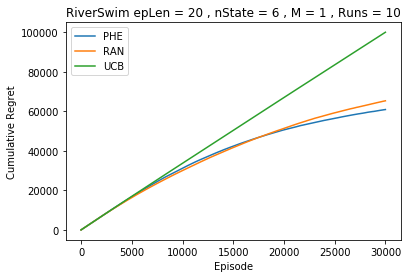

In [54]:
R_PHE_avg = np.mean(R_PHE,axis=0)
R_RAN_avg = np.mean(R_RAN,axis=0)
R_UCB_avg = np.mean(R_UCB,axis=0)


plt.plot(Opt_Reward - R_PHE_avg,label = 'PHE')
plt.plot(Opt_Reward - R_RAN_avg,label = 'RAN')
plt.plot(Opt_Reward - R_UCB_avg,label = 'UCB')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Regret')
plt.title('RiverSwim epLen = '+str(H)+' , nState = '+str(S)+' , M = '+str(M)+' , Runs = '+str(runs))
plt.savefig('PHE_' +str(S)+'_'+str(K)+'.pdf')
plt.show()

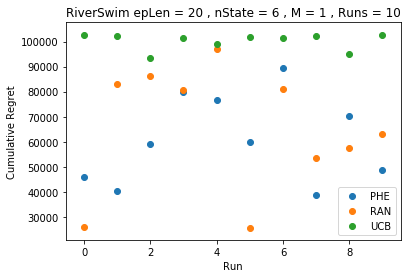

In [55]:
plt.scatter(x=range(runs),y=Opt_Reward[-1] - R_PHE[:,-1],label = 'PHE')
plt.scatter(x=range(runs),y=Opt_Reward[-1] - R_RAN[:,-1],label = 'RAN')
plt.scatter(x=range(runs),y=Opt_Reward[-1] - R_UCB[:,-1],label = 'UCB')


plt.legend()
plt.xlabel('Run')
plt.ylabel('Cumulative Regret')
plt.title('RiverSwim epLen = '+str(H)+' , nState = '+str(S)+' , M = '+str(M)+' , Runs = '+str(runs))
plt.savefig('PHE_scatter_' +str(S)+'_'+str(K)+'.pdf')
plt.show()

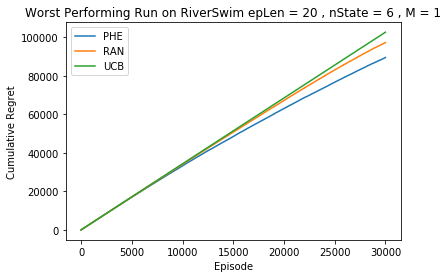

In [56]:
i_phe = np.argmin(R_PHE[:,-1])
i_ran = np.argmin(R_RAN[:,-1])
i_ucb = np.argmin(R_UCB[:,-1])


R_phe_min = R_PHE[i_phe,:]
R_ran_min = R_RAN[i_ran,:]
R_ucb_min = R_UCB[i_ucb,:]

plt.plot(Opt_Reward - R_phe_min,label = 'PHE')
plt.plot(Opt_Reward - R_ran_min,label = 'RAN')
plt.plot(Opt_Reward - R_ucb_min,label = 'UCB')


plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Regret')
plt.title('Worst Performing Run on RiverSwim epLen = '+str(H)+' , nState = '+str(S)+' , M = '+str(M))
plt.savefig('PHE_min_' +str(S)+'_'+str(K)+'.pdf')
plt.show()

In [178]:
sum(sum(agent.Sigma[-1,:,:]))

20010.0

In [191]:
Opt_Reward - R_avg

array([3.89232841e+00, 7.78465683e+00, 1.16769852e+01, ...,
       7.78387836e+04, 7.78426759e+04, 7.78465683e+04])